# 10718 Team Tensor Group Project

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers). 

Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, let's assume that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has ** time to review and support only 10% of the projects posted to the platform on a given day**. 

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to **identify projects that are least likely to be fully funded before they expire**  and pass them off to the digital content expert for review.


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

# Import Statements

In [ ]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import timedelta
from random import randrange
# Import Numpy
import numpy as np
# Import Scikit Learn Ridge Regression
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
# Seaborn
import seaborn as sns

# Getting Set Up



### Mount Google Drive Folder

In [ ]:
# Mount Folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Move to Data Folder

In [ ]:
%cd gdrive/MyDrive/10718/Data

/content/gdrive/MyDrive/10718/Data


### Download into pandas

In [ ]:
donations = pd.read_csv('donations.csv')
essays = pd.read_csv('essays.csv')
outcomes = pd.read_csv('outcomes.csv')
projects = pd.read_csv('projects.csv')
resources = pd.read_csv('resources.csv')

# Get Main Dataset Dataframe

## Filter Donations for only 120 days after being posted

In [ ]:
# Filter Donations for only four months after project
donate_restrict = donations.merge(projects[["date_posted", "projectid"]], on="projectid", how="left")
donate_restrict["donation_to_project"] = donate_restrict["donation_to_project"] * (
    (pd.to_datetime(donate_restrict["donation_timestamp"]) - 
     pd.to_datetime(donate_restrict["date_posted"])) < pd.Timedelta("120day")).astype(float)

## Get Resources Dataframe and Quantity/Prices of Resources

In [ ]:
# Group Resources Dataframe
res_df = resources.groupby(['projectid','project_resource_type'])['item_unit_price','item_quantity'].sum().reset_index()
res_df['price'] = res_df['item_unit_price']
res_df['quantity'] = res_df['item_quantity']
del res_df['item_unit_price']
del res_df['item_quantity']
# Pivot it to get resources for type
resources_pivot = res_df.pivot(index='projectid',columns='project_resource_type',values=['price','quantity']).reset_index()
resources_pivot.columns = ['_'.join(col).strip() for col in resources_pivot.columns.values]
resources_pivot = resources_pivot.rename(columns={'projectid_':'projectid'})
resources_pivot = resources_pivot.fillna(0)
# Also get total resources
resources_pivot['item_quantity'] = resources_pivot['quantity_Books'] + resources_pivot['quantity_Other'] \
+ resources_pivot['quantity_Supplies'] + resources_pivot['quantity_Technology'] \
+ resources_pivot['quantity_Trips'] + resources_pivot['quantity_Visitors']
resources_pivot['item_price'] = resources_pivot['price_Books'] + resources_pivot['price_Other'] \
+ resources_pivot['price_Supplies'] + resources_pivot['price_Technology'] \
+ resources_pivot['price_Trips'] + resources_pivot['price_Visitors']
print(f"Length of resources dataframe: {len(resources_pivot)}")

<ipython-input-6-68f34ec8ba92>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  res_df = resources.groupby(['projectid','project_resource_type'])['item_unit_price','item_quantity'].sum().reset_index()


Length of resources dataframe: 663729


## Make Final Dataframe

In [ ]:
# Get Total Projects
tot_df = projects.join(donate_restrict.groupby("projectid")["donation_to_project"].sum(), on="projectid", how="left")
tot_df = tot_df.merge(resources_pivot, on="projectid", how="left")
print(f"Projects Merged: {len(tot_df)}")
# Replace NaN Donations with 0
tot_df['donation_to_project'] = tot_df['donation_to_project'].fillna(0)
# Get Fraction Amount Funded (If NaN, it means nothing asked to be fully funded)
tot_df['fraction_funded'] = tot_df['donation_to_project']/tot_df['total_price_excluding_optional_support']
tot_df['fraction_funded'] = tot_df['fraction_funded'].fillna(1)
# Make it a datatime feature
tot_df['date_posted'] = pd.to_datetime(tot_df['date_posted'])
tot_df['year'] = tot_df['date_posted'].dt.year
# Make Binary on Fully Funded
tot_df["fully_funded"] = 0
tot_df.loc[tot_df["fraction_funded"] >= 1, "fully_funded"] = 1
# Get Rid of Rows without a Zip Value
tot_df = tot_df[tot_df['school_zip'].notna()]
print(f"Final Total DF: {len(tot_df)}")

Projects Merged: 664098
Final Total DF: 664094


# Add New Features

In [ ]:
# Add Random Datatime Column
tot_df['datetime_posted'] = tot_df.apply(lambda x : x.date_posted + timedelta(seconds=x.name), axis=1)

In [ ]:
def calculate_previous_avg(data, date_col, group_col, value_col, days=120):
    """
    Calculate the previous average
    
    Args:
        data (DataFrame): The input DataFrame.
        date_col (str): The name of the column containing the date values.
        group_col (str): The name of the column containing the group values.
        value_col (str): The name of the column containing the values to average.
    
    Returns:
        A Pandas Series containing the calculated averages for each row in the input DataFrame.
    """
    # Restrict Data
    data = data[[date_col, group_col, value_col]]

    # Sort the data by date
    data = data.sort_values([date_col]).set_index(date_col)

    # Now Get Expanding Sum and Rolling Sum for Last 120 Days
    expand_sum = data.groupby(group_col)[value_col].expanding(1).sum().reset_index().sort_values(date_col)
    roll_sum = data.groupby(group_col)[value_col].rolling(f"{days}D").sum().reset_index().sort_values(date_col)
    prev_sum = expand_sum[value_col]-roll_sum[value_col]

    # Now Get Expanding Count and Rolling Count for Last 120 Days
    expand_count = data.groupby(group_col)[value_col].expanding(1).count().reset_index().sort_values(date_col)
    roll_count = data.groupby(group_col)[value_col].rolling(f"{days}D").count().reset_index().sort_values(date_col)
    prev_count = expand_count[value_col]-roll_count[value_col]

    # Add to Dataframe
    expand_sum[f'{group_col}_prev_avg'] = prev_sum.div(prev_count).fillna(0)
    del expand_sum[value_col]
    return expand_sum

In [ ]:
retAns = calculate_previous_avg(tot_df,'datetime_posted','teacher_acctid','fully_funded')
tot_df = tot_df.merge(retAns,on=['datetime_posted','teacher_acctid'])
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
retAns = calculate_previous_avg(tot_df,'datetime_posted','schoolid','fully_funded')
tot_df = tot_df.merge(retAns,on=['datetime_posted','schoolid'])
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
retAns = calculate_previous_avg(tot_df,'datetime_posted','school_zip','fully_funded')
tot_df = tot_df.merge(retAns,on=['datetime_posted','school_zip'])
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
def add_donations_after_time(df,days=7):
  # Get Donations a week after the project
  new_donation = donations.merge(projects[["date_posted", "projectid"]], on="projectid", how="left")
  new_donation[f"donations_after_{days}days"] = new_donation["donation_to_project"] * (
      (pd.to_datetime(new_donation["donation_timestamp"]) - 
      pd.to_datetime(new_donation["date_posted"])) < pd.Timedelta(f"{days}day")).astype(float)
  new_donation = new_donation.groupby("projectid")[f"donations_after_{days}days"].sum().reset_index()
  # Add to Project Donations
  df = df.merge(new_donation, on="projectid",how='left')
  df[f"donations_after_{days}days"] = df[f"donations_after_{days}days"].fillna(0)
  # Add fraction funded after x days with na filled with 1
  df[f"fraction_funded_after_{days}days"] = df[f"donations_after_{days}days"]/df['total_price_excluding_optional_support']
  df[f"fraction_funded_after_{days}days"] = df[f"fraction_funded_after_{days}days"].fillna(1)
  return df

In [ ]:
tot_df = add_donations_after_time(tot_df,days=5)
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
tot_df = add_donations_after_time(tot_df,days=10)
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
tot_df = add_donations_after_time(tot_df,days=15)
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
tot_df = add_donations_after_time(tot_df,days=20)
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
tot_df = add_donations_after_time(tot_df,days=25)
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


In [ ]:
tot_df = add_donations_after_time(tot_df,days=30)
print(f"New Length of Dataframe: {len(tot_df)}")

New Length of Dataframe: 664094


# Imputation Methods

In [ ]:
def label_null_as_false(df,cols):
  df[cols] = df[cols].fillna("f")

In [ ]:
# Fill NaN False
cols = ["teacher_teach_for_america","teacher_ny_teaching_fellow","school_nlns","school_kipp","school_magnet","school_charter"]
label_null_as_false(tot_df,cols)

In [ ]:
def label_null_with_most_popular_and_flag(df,cols):
  df[[i+"_flag" for i in cols]] = df[cols].isnull()
  for col in cols: df[col] = df[col].fillna(df[col].mode().iloc[0])

In [ ]:
# Fill NaN with Most Popular Category and Flag
cols = ["primary_focus_subject","primary_focus_area","resource_type","poverty_level"]
label_null_with_most_popular_and_flag(tot_df,cols)

In [ ]:
def label_null_with_mean_and_flag(df,cols):
  for col in cols:
    if df[col].isnull().values.any(): 
      df[f"{col}_flag"] = df[col].isnull()
  for col in cols: 
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
# Fill NaN with Mean and Flag
cols = ["total_price_excluding_optional_support","students_reached"]
label_null_with_mean_and_flag(tot_df,cols)

# Data Pre-processing Step

## Add Class Weight based on sensitive feature

In [ ]:
# Convert Back to Pandas Dataframe
def calc_weights(df,sen_feat,label):
  retDict = {}
  for feat in df[sen_feat].unique():
    if feat == np.NaN: continue
    for lab in df[label].unique():
      tot_len = len(df)
      len_sen = len(df[df[sen_feat] == feat])
      len_lab = len(df[df[label] == lab])
      len_both = len(df[(df[label] == lab) & (df[sen_feat] == feat)])
      retDict[(feat,lab)] = (len_sen * len_lab) / (tot_len *len_both)
  return retDict

In [ ]:
# Features
sensitive_features = 'poverty_level'
label = "fully_funded"
# Calc Dict
retDict = calc_weights(tot_df,sensitive_features,label)
print(retDict)

{('highest poverty', 0): 1.0658498162870846, ('highest poverty', 1): 0.9515161624025906, ('high poverty', 0): 0.9280370868048566, ('high poverty', 1): 1.0683232218693535, ('moderate poverty', 0): 0.9044299306989789, ('moderate poverty', 1): 1.095470675752226, ('low poverty', 0): 0.9604568404472861, ('low poverty', 1): 1.035149475157968}


In [ ]:
# Probabilitiy of Classification
for feat in tot_df[sensitive_features].unique():
    len_sen = len(tot_df[tot_df[sensitive_features] == feat])
    len_both = len(tot_df[(tot_df[label] == 1) & (tot_df[sensitive_features] == feat)])
    print(f"feat: {feat}, prob: {len_both/len_sen}")

## Add Weight

In [ ]:
def add_weight(df,sen_feat,label,retDict):
  df['weight'] = [retDict[(i,j)] for i,j in zip(df[sen_feat],df[label])]

In [ ]:
add_weight(tot_df,sensitive_features,label,retDict)

## Do Re-sampling

In [ ]:
def resample(df,sen_feat,label,retDict):
  retDf = []
  for i,j in retDict:
    sub_df = df[(df[sen_feat] == i) & (df[label] == j)]
    sampLen = int(len(sub_df) * retDict[(i,j)])
    retDf.append(sub_df.sample(sampLen,replace=True))
  return pd.concat(retDf).reset_index()

In [ ]:
resamp_tot_df = resample(tot_df,sensitive_features,label,retDict)

In [ ]:
# Probabilitiy of Classification
for feat in resamp_tot_df[sensitive_features].unique():
    len_sen = len(resamp_tot_df[resamp_tot_df[sensitive_features] == feat])
    len_both = len(resamp_tot_df[(resamp_tot_df[label] == 1) & (resamp_tot_df[sensitive_features] == feat)])
    print(f"feat: {feat}, prob: {len_both/len_sen}")

feat: highest poverty, prob: 0.5480202563861856
feat: high poverty, prob: 0.5480179764922793
feat: moderate poverty, prob: 0.5480207226354942
feat: low poverty, prob: 0.5479952124476362


# Base Rate

In [ ]:
# Get Baseline Rate A
print(tot_df["fully_funded"].value_counts()/len(tot_df)*100)

1    54.802031
0    45.197969
Name: fully_funded, dtype: float64


In [ ]:
# Get Baseline Rate B
print(resamp_tot_df["fully_funded"].value_counts()/len(resamp_tot_df)*100)

1    54.801909
0    45.198091
Name: fully_funded, dtype: float64


# Baseline Rate

In [ ]:
def get_baseline_rate(df, feature, q=0.9):
  baseline = df[feature].quantile(q=q)
  print(f"Baseline Value: {baseline}")
  check_df = df[df[feature] > baseline]
  print(f"Percentile: {len(check_df)/len(df)*100:.2f}")
  print(check_df["fully_funded"].value_counts()/len(check_df)*100)

In [ ]:
get_baseline_rate(tot_df,'total_price_excluding_optional_support')

Baseline Value: 853.98
Percentile: 9.94
0    63.402038
1    36.597962
Name: fully_funded, dtype: float64


In [ ]:
get_baseline_rate(tot_df,'total_price_including_optional_support')

Baseline Value: 1010.58
Percentile: 10.00
0    63.58667
1    36.41333
Name: fully_funded, dtype: float64


In [ ]:
get_baseline_rate(tot_df,'students_reached')

Baseline Value: 200.0
Percentile: 9.26
1    51.998568
0    48.001432
Name: fully_funded, dtype: float64


## Test-Train Split

In [ ]:
# Get ideas about datetime range
print(f"Min Date: {tot_df['date_posted'].min()}, Max Date: {tot_df['date_posted'].max()}")

Min Date: 2002-09-13 00:00:00, Max Date: 2014-05-12 00:00:00


In [ ]:
def test_train_split(df, feature, train_time, valid_time, model_time, n_of_splits=3, startdate = "2008-01-01"):
  trainList = []
  validList = []
  startdate = pd.to_datetime(startdate)
  for split in range(n_of_splits):
    train_data = df[(startdate <= df[feature]) & (df[feature] < startdate+train_time)]
    trainList.append(train_data)
    valid_data = df[(startdate + train_time <= df[feature]) & (df[feature] < startdate + train_time + valid_time)]
    validList.append(valid_data)
    print(f"Train Min Time: {train_data[feature].min()}, Max Time: {train_data[feature].max()}")
    print(f"Train Min Label Time: {train_data[feature].min() + pd.Timedelta(120,'d')} + Max Label Time: {train_data[feature].max() + pd.Timedelta(120,'d')}")
    print(f"Valid Min Time: {valid_data[feature].min()}, Max Time: {valid_data[feature].max()}")
    print(f"Valid Min Label Time: {valid_data[feature].min() + pd.Timedelta(120,'d')} + Valid Label Time: {valid_data[feature].max() + pd.Timedelta(120,'d')}")
    print()
    # Go to Next Data
    startdate += model_time
  return trainList, validList

In [ ]:
trainList, validList = test_train_split(tot_df,'date_posted',pd.Timedelta(360,"d"),pd.Timedelta(120,"d"),pd.Timedelta(480,"d"))
#trainList, validList = test_train_split(resamp_tot_df,'date_posted',pd.Timedelta(360,"d"),pd.Timedelta(120,"d"),pd.Timedelta(480,"d"))

Train Min Time: 2008-01-01 00:00:00, Max Time: 2008-12-25 00:00:00
Train Min Label Time: 2008-04-30 00:00:00 + Max Label Time: 2009-04-24 00:00:00
Valid Min Time: 2008-12-26 00:00:00, Max Time: 2009-04-24 00:00:00
Valid Min Label Time: 2009-04-25 00:00:00 + Valid Label Time: 2009-08-22 00:00:00

Train Min Time: 2009-04-25 00:00:00, Max Time: 2010-04-19 00:00:00
Train Min Label Time: 2009-08-23 00:00:00 + Max Label Time: 2010-08-17 00:00:00
Valid Min Time: 2010-04-20 00:00:00, Max Time: 2010-08-17 00:00:00
Valid Min Label Time: 2010-08-18 00:00:00 + Valid Label Time: 2010-12-15 00:00:00

Train Min Time: 2010-08-18 00:00:00, Max Time: 2011-08-12 00:00:00
Train Min Label Time: 2010-12-16 00:00:00 + Max Label Time: 2011-12-10 00:00:00
Valid Min Time: 2011-08-13 00:00:00, Max Time: 2011-12-10 00:00:00
Valid Min Label Time: 2011-12-11 00:00:00 + Valid Label Time: 2012-04-08 00:00:00



# Train Features Base Rates

In [ ]:
def get_test_train_baseline_rate(train_df, test_df, feature, per=0.1):
  baseline = train_df[feature].quantile(q=1-per)
  # Get Precision
  prec_df = test_df[test_df[feature] > baseline]
  precision = 1 - prec_df['fully_funded'].mean()
  # Get Recall
  recall = (test_df[test_df["fully_funded"] == 0][feature] > baseline).astype(float).mean()
  return baseline, precision, recall

In [ ]:
for i in range(3):
  print(f"Train Test Split: {i}")
  train_data, valid_data = trainList[i], validList[i]
  print(valid_data["fully_funded"].value_counts()/len(valid_data)*100)
  print("Feature: total_price_excluding_optional_support")
  _, precision, recall = get_test_train_baseline_rate(train_data,valid_data,"total_price_excluding_optional_support")
  print(f"Precision: {precision*100:.2f}%")
  print(f"Recall: {recall*100:.2f}%")
  print("\nFeature: students_reached")
  _, precision, recall = get_test_train_baseline_rate(train_data,valid_data,"students_reached")
  print(f"Precision: {precision*100:.2f}%")
  print(f"Recall: {recall*100:.2f}%")
  print("\nFeature: total_price_including_optional_support")
  _, precision, recall = get_test_train_baseline_rate(train_data,valid_data,"total_price_including_optional_support")
  print(f"Precision: {precision*100:.2f}%")
  print(f"Recall: {recall*100:.2f}%")
  print()

Train Test Split: 0
1    55.691434
0    44.308566
Name: fully_funded, dtype: float64
Feature: total_price_excluding_optional_support
Precision: 55.53%
Recall: 13.87%

Feature: students_reached
Precision: 47.43%
Recall: 11.24%

Feature: total_price_including_optional_support
Precision: 55.53%
Recall: 13.87%

Train Test Split: 1
1    54.702415
0    45.297585
Name: fully_funded, dtype: float64
Feature: total_price_excluding_optional_support
Precision: 59.62%
Recall: 11.81%

Feature: students_reached
Precision: 46.82%
Recall: 10.34%

Feature: total_price_including_optional_support
Precision: 59.31%
Recall: 9.68%

Train Test Split: 2
1    64.49924
0    35.50076
Name: fully_funded, dtype: float64
Feature: total_price_excluding_optional_support
Precision: 48.20%
Recall: 13.71%

Feature: students_reached
Precision: 39.16%
Recall: 11.92%

Feature: total_price_including_optional_support
Precision: 48.20%
Recall: 13.71%



## Make Feature Precision and Recall Plot

In [ ]:
def calc_prec_and_rec(trainList, validList, feature):
  records_df = []
  for i in range(3):
    train_data, valid_data = trainList[i], validList[i]
    for percentile in np.linspace(0, 1, num=51):
      baseline, prec, rec = get_test_train_baseline_rate(train_data, valid_data, feature, per=percentile)
      if percentile == 0.1:
        print(f"Split: {i}, P: {prec*100:.2f}%, R: {rec*100:.2f}%")
      # Add to Records
      records_df.append(
                dict(seed=i, percentile=percentile, value=rec, type="recall")
            )
      records_df.append(
                dict(seed=i, percentile=percentile, value=prec, type="precision")
            )
  # Return Records Dataframe
  records_df = pd.DataFrame.from_records(records_df)
  records_df = records_df.fillna(1)
  return records_df

Split: 0, P: 55.53%, R: 13.87%
Split: 1, P: 59.62%, R: 11.81%
Split: 2, P: 48.20%, R: 13.71%


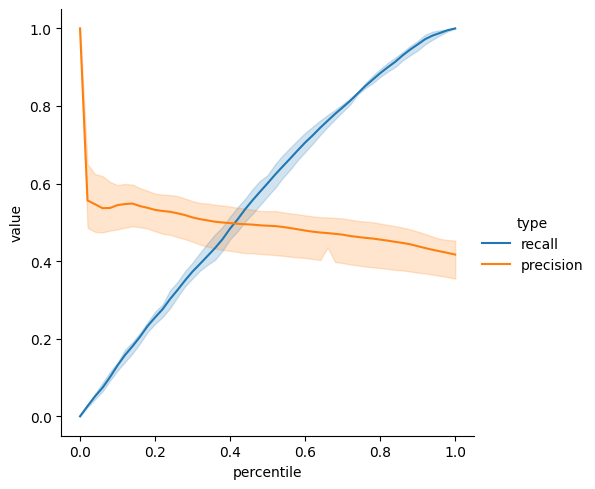

In [ ]:
records_df = calc_prec_and_rec(trainList,validList,"total_price_excluding_optional_support")
sns.relplot(data=records_df, x="percentile", y="value", hue="type", kind="line")

## Make Model

### Get Model Dataset

In [ ]:
# Features
num_features = ["students_reached","total_price_excluding_optional_support","teacher_acctid_prev_avg", "schoolid_prev_avg","school_zip_prev_avg",
                "fraction_funded_after_5days","fraction_funded_after_10days","fraction_funded_after_15days","fraction_funded_after_20days",
                "fraction_funded_after_25days","fraction_funded_after_30days"]
cat_features = ["teacher_teach_for_america","teacher_ny_teaching_fellow", "primary_focus_subject","primary_focus_area","school_nlns", "school_kipp", 
                "school_magnet", "school_charter", "resource_type","poverty_level"]
flag_features = ["primary_focus_subject_flag","primary_focus_area_flag","resource_type_flag","poverty_level_flag","students_reached_flag"]
split_features = ["date_posted","weight"]
features = num_features + cat_features + split_features# + flag_features
# Y variables
result = ['fully_funded']

In [ ]:
# Data Filtering:
# I test dropping NaN data since there shouldn't be any left after filtering
print(f"Number of entries before filtering {len(tot_df)}")
data_df = tot_df[features+result]
data_df = data_df.dropna()
print(f"Number of entries after filtering {len(tot_df)}")

Number of entries before filtering 664094
Number of entries after filtering 664094


In [ ]:
# Get X, Y
data_dummy_df = pd.get_dummies(data_df,columns=cat_features)# + flag_features)

In [ ]:
# Test Train Split
trainModelList, validModelList = test_train_split(data_dummy_df,'date_posted',pd.Timedelta(360,"d"),pd.Timedelta(120,"d"),pd.Timedelta(480,"d"))

Train Min Time: 2008-01-01 00:00:00, Max Time: 2008-12-25 00:00:00
Train Min Label Time: 2008-04-30 00:00:00 + Max Label Time: 2009-04-24 00:00:00
Valid Min Time: 2008-12-26 00:00:00, Max Time: 2009-04-24 00:00:00
Valid Min Label Time: 2009-04-25 00:00:00 + Valid Label Time: 2009-08-22 00:00:00

Train Min Time: 2009-04-25 00:00:00, Max Time: 2010-04-19 00:00:00
Train Min Label Time: 2009-08-23 00:00:00 + Max Label Time: 2010-08-17 00:00:00
Valid Min Time: 2010-04-20 00:00:00, Max Time: 2010-08-17 00:00:00
Valid Min Label Time: 2010-08-18 00:00:00 + Valid Label Time: 2010-12-15 00:00:00

Train Min Time: 2010-08-18 00:00:00, Max Time: 2011-08-12 00:00:00
Train Min Label Time: 2010-12-16 00:00:00 + Max Label Time: 2011-12-10 00:00:00
Valid Min Time: 2011-08-13 00:00:00, Max Time: 2011-12-10 00:00:00
Valid Min Label Time: 2011-12-11 00:00:00 + Valid Label Time: 2012-04-08 00:00:00



### Train Model

In [ ]:
def train_model(clf,trainModelList,validModelList):
  new_train_list, new_model_list = [], []
  for i in range(3):
    # Get Data
    train_data, valid_data = trainModelList[i], validModelList[i]
    X_train, y_train = train_data.drop(['fully_funded','date_posted','weight'], axis=1), train_data['fully_funded']
    train_weight = train_data["weight"]
    X_test, y_test = valid_data.drop(['fully_funded','date_posted','weight'], axis=1), valid_data['fully_funded']
    #test_weight = valid_data["weight"]
    clf.fit(X_train,y_train,train_weight)
    # Add Probaility Columns
    train_data, valid_data = train_data.copy(), valid_data.copy()
    train_data['prob'] = clf.predict_proba(X_train)[:, 0]
    valid_data['prob'] = clf.predict_proba(X_test)[:, 0]
    new_train_list.append(train_data)
    new_model_list.append(valid_data)
  #Now Get Prec vs Recall Dataframe
  return calc_prec_and_rec(new_train_list,new_model_list,"prob")

Split: 0, P: 87.48%, R: 15.63%
Split: 1, P: 75.86%, R: 14.80%
Split: 2, P: 73.62%, R: 17.72%


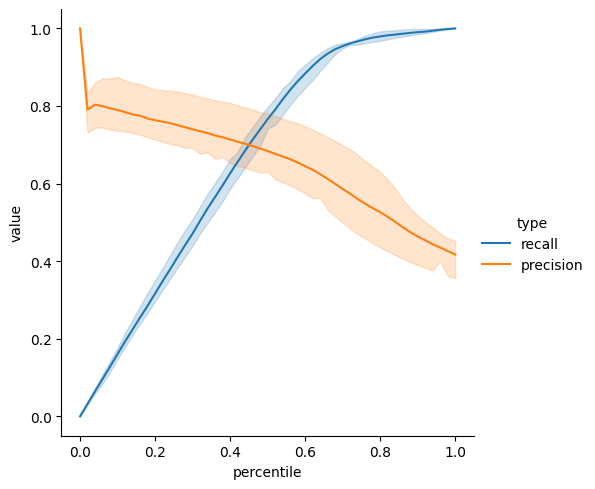

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000,C=1)
records_df = train_model(clf,trainModelList, validModelList)
sns.relplot(data=records_df, x="percentile", y="value", hue="type", kind="line")

Split: 0, P: 91.12%, R: 11.28%
Split: 1, P: 78.12%, R: 12.95%
Split: 2, P: 77.42%, R: 16.06%


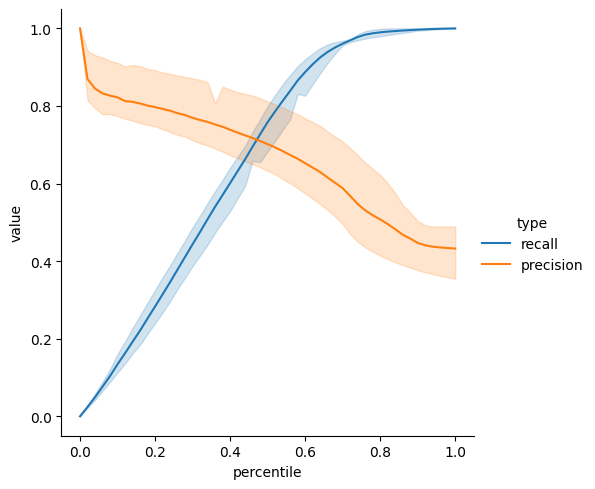

In [ ]:
clf = RandomForestClassifier(max_depth=16,n_estimators=500)
records_df = train_model(clf,trainModelList, validModelList)
sns.relplot(data=records_df, x="percentile", y="value", hue="type", kind="line")

/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as keyword args.
  warnings.warn(msg, FutureWarning)


Split: 0, P: 90.77%, R: 12.35%
Split: 1, P: 79.29%, R: 15.79%
Split: 2, P: 74.71%, R: 16.89%


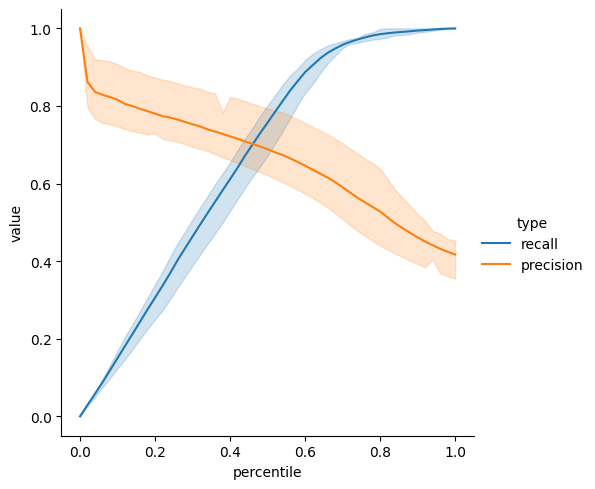

In [ ]:
clf = XGBClassifier(n_estimators=100,max_depth=8)
records_df = train_model(clf,trainModelList, validModelList)
sns.relplot(data=records_df, x="percentile", y="value", hue="type", kind="line")

# Plot Precision @ 10 Over Eval Start Time

In [ ]:
trainListPlot, validListPlot = test_train_split(data_dummy_df,'date_posted',pd.Timedelta(360,"d"),pd.Timedelta(120,"d"),pd.Timedelta(120,"d"),n_of_splits=22,startdate = "2006-01-01")

Train Min Time: 2006-01-01 00:00:00, Max Time: 2006-12-26 00:00:00
Train Min Label Time: 2006-05-01 00:00:00 + Max Label Time: 2007-04-25 00:00:00
Valid Min Time: 2006-12-27 00:00:00, Max Time: 2007-04-25 00:00:00
Valid Min Label Time: 2007-04-26 00:00:00 + Valid Label Time: 2007-08-23 00:00:00

Train Min Time: 2006-05-01 00:00:00, Max Time: 2007-04-25 00:00:00
Train Min Label Time: 2006-08-29 00:00:00 + Max Label Time: 2007-08-23 00:00:00
Valid Min Time: 2007-04-26 00:00:00, Max Time: 2007-08-23 00:00:00
Valid Min Label Time: 2007-08-24 00:00:00 + Valid Label Time: 2007-12-21 00:00:00

Train Min Time: 2006-08-29 00:00:00, Max Time: 2007-08-23 00:00:00
Train Min Label Time: 2006-12-27 00:00:00 + Max Label Time: 2007-12-21 00:00:00
Valid Min Time: 2007-08-24 00:00:00, Max Time: 2007-12-21 00:00:00
Valid Min Label Time: 2007-12-22 00:00:00 + Valid Label Time: 2008-04-19 00:00:00

Train Min Time: 2006-12-27 00:00:00, Max Time: 2007-12-21 00:00:00
Train Min Label Time: 2007-04-26 00:00:00 

In [ ]:
def make_plot(models,trainModelList,validModelList):
  start_date = []
  model_dict = {}
  for i in tqdm(range(len(trainModelList))):
    # Get Data
    train_data, valid_data = trainModelList[i], validModelList[i]
    start_date.append(valid_data['date_posted'].min())
    X_train, y_train = train_data.drop(['fully_funded','date_posted','weight'], axis=1), train_data['fully_funded']
    train_weight = train_data["weight"]
    X_test, y_test = valid_data.drop(['fully_funded','date_posted','weight'], axis=1), valid_data['fully_funded']
    # Go Through
    for name, clf in models:
      # Check Dictionary
      if name not in model_dict: model_dict[name] = []
      # Than get precision
      if name == "base_rate":
        prec = 1 - valid_data["fully_funded"].mean()
      elif name == "commonsense":
        _, prec, _ = get_test_train_baseline_rate(train_data, valid_data, clf, per=0.1)
      else: # Train Model and get precision
        clf.fit(X_train,y_train,sample_weight=train_weight)
        print(f"\nFinished Fitting: {name}")
        train_data, valid_data = train_data.copy(), valid_data.copy()
        train_data['prob'] = clf.predict_proba(X_train)[:, 0]
        valid_data['prob'] = clf.predict_proba(X_test)[:, 0]
        _, prec, _ = get_test_train_baseline_rate(train_data, valid_data, "prob", per=0.1)
      # Add to Dictionary
      model_dict[name].append(prec)

  # Now Plot Information
  for name, _ in models:
    y = model_dict[name]
    x = start_date
    plt.plot(x, y, label=name)

  # Plot the graph
  plt.ylabel("precision @ 10%")
  plt.xlabel("Eval. time start")
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.title("Precision @ 10% vs. Eval start time")
  plt.xticks(rotation=45)
  plt.show()

  # Now Get Prec vs Recall Dataframe
  return

## Make Top Model Plot

In [ ]:
models = [("base_rate",""), ("commonsense","total_price_excluding_optional_support"),
          ("logistic_regression",LogisticRegression(random_state=0, max_iter=1000,C=1)), 
          #("random_forest",RandomForestClassifier(max_depth=16,n_estimators=500)),
          ("xgboost",XGBClassifier(n_estimators=100,max_depth=8))]

  0%|          | 0/22 [00:00<?, ?it/s]


Finished Fitting: logistic_regression


  5%|▍         | 1/22 [00:11<04:09, 11.87s/it]


Finished Fitting: xgboost

Finished Fitting: logistic_regression


  9%|▉         | 2/22 [00:24<04:06, 12.30s/it]


Finished Fitting: xgboost

Finished Fitting: logistic_regression


 14%|█▎        | 3/22 [00:40<04:24, 13.93s/it]


Finished Fitting: xgboost

Finished Fitting: logistic_regression

Finished Fitting: xgboost


 18%|█▊        | 4/22 [01:03<05:12, 17.38s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 23%|██▎       | 5/22 [01:29<05:49, 20.54s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 27%|██▋       | 6/22 [01:54<05:57, 22.33s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 32%|███▏      | 7/22 [02:20<05:51, 23.43s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 36%|███▋      | 8/22 [02:57<06:27, 27.69s/it]/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression

Finished Fitting: xgboost


 41%|████      | 9/22 [03:37<06:51, 31.62s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 45%|████▌     | 10/22 [04:25<07:17, 36.46s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 50%|█████     | 11/22 [05:04<06:49, 37.23s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 55%|█████▍    | 12/22 [05:44<06:20, 38.07s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 59%|█████▉    | 13/22 [06:29<06:02, 40.30s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 64%|██████▎   | 14/22 [07:42<06:41, 50.22s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 68%|██████▊   | 15/22 [09:03<06:55, 59.36s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 73%|███████▎  | 16/22 [10:22<06:32, 65.42s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 77%|███████▋  | 17/22 [11:43<05:50, 70.06s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 82%|████████▏ | 18/22 [13:13<05:04, 76.03s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 86%|████████▋ | 19/22 [14:44<04:01, 80.43s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 91%|█████████ | 20/22 [16:07<02:42, 81.45s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


 95%|█████████▌| 21/22 [17:32<01:22, 82.50s/it]


Finished Fitting: logistic_regression

Finished Fitting: xgboost


100%|██████████| 22/22 [18:55<00:00, 51.63s/it]


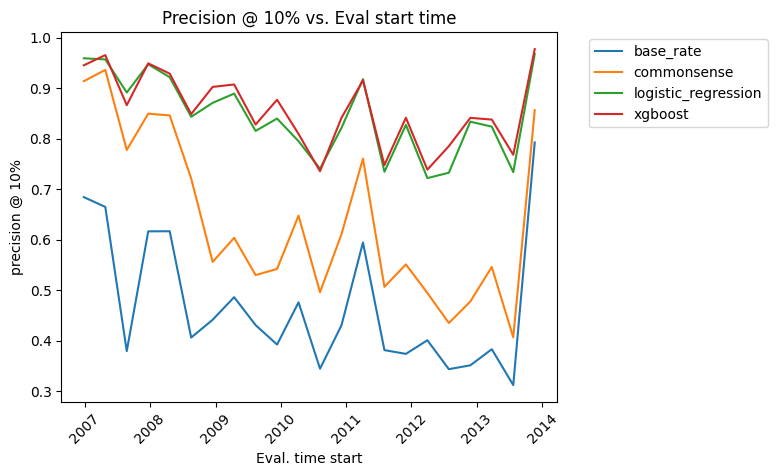

In [ ]:
make_plot(models,trainListPlot,validListPlot)

## Make Conglomeration Plot

In [ ]:
models = [("base_rate",""), ("commonsense","total_price_excluding_optional_support")]

# Add Logistic Regression Models
for c in [0.25,0.5,1,2,4]:
  models.append((f"logistic_regression_c_{c}",LogisticRegression(random_state=0, max_iter=1000,C=c)))

# Add Random Forest Models
for depth in [8,12,16]:
  for n_estim in [100,300,500]:
    models.append((f"random_forest_dpth_{depth}_estim_{n_estim}",RandomForestClassifier(max_depth=depth,n_estimators=n_estim)))

# Add XGBoost Models
for depth in [6,8,10]:
  for n_estim in [100,300,500]:
    models.append((f"xgboost_dpth_{depth}_estim_{n_estim}",XGBClassifier(n_estimators=n_estim,max_depth=depth)))

  0%|          | 0/22 [00:00<?, ?it/s]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

  5%|▍         | 1/22 [04:21<1:31:33, 261.60s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

  9%|▉         | 2/22 [08:57<1:30:05, 270.28s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 14%|█▎        | 3/22 [13:54<1:29:21, 282.19s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 18%|█▊        | 4/22 [20:49<1:40:23, 334.63s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 23%|██▎       | 5/22 [30:12<1:58:10, 417.10s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 27%|██▋       | 6/22 [40:25<2:08:58, 483.65s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 32%|███▏      | 7/22 [50:27<2:10:34, 522.27s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 36%|███▋      | 8/22 [1:00:50<2:09:21, 554.40s/it]


Finished Fitting: logistic_regression_c_0.25


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fittin

 41%|████      | 9/22 [1:12:40<2:10:38, 602.93s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 45%|████▌     | 10/22 [1:26:57<2:16:18, 681.52s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 50%|█████     | 11/22 [1:41:25<2:15:24, 738.63s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 55%|█████▍    | 12/22 [1:56:59<2:12:59, 797.94s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 59%|█████▉    | 13/22 [2:15:20<2:13:26, 889.66s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 64%|██████▎   | 14/22 [2:39:06<2:20:13, 1051.71s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 68%|██████▊   | 15/22 [3:04:20<2:18:57, 1191.01s/it]


Finished Fitting: logistic_regression_c_0.25


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 73%|███████▎  | 16/22 [3:29:30<2:08:43, 1287.20s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 77%|███████▋  | 17/22 [3:55:49<1:54:34, 1374.87s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_0.25


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 82%|████████▏ | 18/22 [4:22:13<1:35:50, 1437.69s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 86%|████████▋ | 19/22 [4:50:43<1:15:58, 1519.63s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitting: xgboost_dpth_10_estim_300

Finished Fitting: xgboost_dpth_10_estim_500


 91%|█████████ | 20/22 [5:15:45<50:28, 1514.37s/it]  


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

 95%|█████████▌| 21/22 [5:42:28<25:40, 1540.73s/it]


Finished Fitting: logistic_regression_c_0.25

Finished Fitting: logistic_regression_c_0.5

Finished Fitting: logistic_regression_c_1

Finished Fitting: logistic_regression_c_2

Finished Fitting: logistic_regression_c_4

Finished Fitting: random_forest_dpth_8_estim_100

Finished Fitting: random_forest_dpth_8_estim_300

Finished Fitting: random_forest_dpth_8_estim_500

Finished Fitting: random_forest_dpth_12_estim_100

Finished Fitting: random_forest_dpth_12_estim_300

Finished Fitting: random_forest_dpth_12_estim_500

Finished Fitting: random_forest_dpth_16_estim_100

Finished Fitting: random_forest_dpth_16_estim_300

Finished Fitting: random_forest_dpth_16_estim_500

Finished Fitting: xgboost_dpth_6_estim_100

Finished Fitting: xgboost_dpth_6_estim_300

Finished Fitting: xgboost_dpth_6_estim_500

Finished Fitting: xgboost_dpth_8_estim_100

Finished Fitting: xgboost_dpth_8_estim_300

Finished Fitting: xgboost_dpth_8_estim_500

Finished Fitting: xgboost_dpth_10_estim_100

Finished Fitti

100%|██████████| 22/22 [6:13:23<00:00, 1018.36s/it]


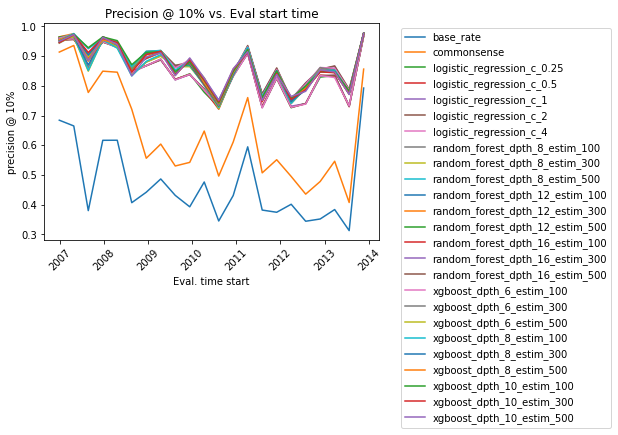

In [ ]:
make_plot(models,trainListPlot,validListPlot)